In [1]:
# modules needed for inline matplotlib and seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()  # set plotting style to seaborn

In [2]:
# modules
import pandas as pd

# sklearn modules
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
# add project path into system path so can do relative import of project modules
import sys
sys.path.append('..')
from utils.utils import GROUPSET_RANKING

## Load Data File

In [4]:
orig_df = pd.read_csv('../data/munged_data/combined/combined_munged_01022020.csv')
orig_df.head()

,site,bike_type,product_id,href,description,brand,price,msrp,frame_material,model_year,...,handlebar_material,fd_groupset,rd_groupset,cassette_groupset,crankset_material,crankset_groupset,seatpost_material,chain_groupset,shifter_groupset,price_x
0,jenson,mountain,BI178B01,/Evil-Wreckoning-XT-Jenson-USA-Exclusive-Build,Evil Wreckoning XT Jenson USA Exclusive Build,Evil,3499.99,5800.00,NaN,NaN,...,NaN,NaN,shimano deore xt,shimano deore xt,NaN,race face,NaN,shimano 105,shimano deore xt,NaN
1,jenson,mountain,BI001298,/Evil-Following-V1-GX-Eagle-Jenson-USA-Exclusi...,Evil Following V1 GX Eagle Jenson USA Exclusiv...,Evil,3499.99,4844.99,carbon,NaN,...,NaN,NaN,sram gx,sram gx eagle,NaN,sram gx,NaN,sram gx,sram gx,NaN
2,jenson,mountain,BI001373,/Ibis-Ripmo-AF-NX-Eagle-Bike-2020,Ibis Ripmo AF NX Eagle Bike 2020,Ibis,2999.00,2999.00,aluminium,2020.0,...,aluminium,NaN,sram nx,sram nx,steel,sram nx,NaN,sram nx,sram nx,NaN
3,jenson,mountain,BI174B07,/Devinci-Spartan-29-NX12S,Devinci Spartan 29 NX 2019,Devinci,2299.99,3299.00,aluminium,2019.0,...,NaN,NaN,sram nx,sram gx eagle,NaN,sram gx,NaN,sram nx,sram nx,NaN
4,jenson,mountain,BI001166,/Niner-Rip-9-Gx-Eagle-Jenson-USA-Exclusive-Build,Niner Rip 9 Gx Eagle Jenson USA Exclusive Build,Niner,2599.99,4300.00,aluminium,NaN,...,NaN,NaN,sram gx,sram nx,NaN,sram gx,NaN,sram nx,sram gx,NaN


### Quick Glance
Let's take a quick glance to see what we're working with to get a better sense of what we're working with.

#### Info
* There are 9596 samples
* 22 columns of which **price**, **msrp**, **price_x** and **model_year** are numeric data, everthing else is categorical.  **price_x** is a duplicate of price, so need merge into price column and drop.
* Many of the fields have missing values; need to determine how to best handle this.

In [5]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9596 entries, 0 to 9595
Data columns (total 22 columns):
site                  9596 non-null object
bike_type             9596 non-null object
product_id            9596 non-null object
href                  9596 non-null object
description           9596 non-null object
brand                 9596 non-null object
price                 9194 non-null float64
msrp                  9596 non-null float64
frame_material        8566 non-null object
model_year            3831 non-null float64
brake_type            8363 non-null object
fork_material         4617 non-null object
handlebar_material    4734 non-null object
fd_groupset           3356 non-null object
rd_groupset           7483 non-null object
cassette_groupset     7183 non-null object
crankset_material     2493 non-null object
crankset_groupset     5008 non-null object
seatpost_material     4264 non-null object
chain_groupset        4712 non-null object
shifter_groupset      6913 non

##### Fill missing price data with price_x values and then drop price_x column.

In [6]:
munged_df = orig_df.copy()
munged_df.price.fillna(munged_df.price_x, inplace=True)
munged_df = munged_df.drop('price_x', axis=1)
munged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9596 entries, 0 to 9595
Data columns (total 21 columns):
site                  9596 non-null object
bike_type             9596 non-null object
product_id            9596 non-null object
href                  9596 non-null object
description           9596 non-null object
brand                 9596 non-null object
price                 9558 non-null float64
msrp                  9596 non-null float64
frame_material        8566 non-null object
model_year            3831 non-null float64
brake_type            8363 non-null object
fork_material         4617 non-null object
handlebar_material    4734 non-null object
fd_groupset           3356 non-null object
rd_groupset           7483 non-null object
cassette_groupset     7183 non-null object
crankset_material     2493 non-null object
crankset_groupset     5008 non-null object
seatpost_material     4264 non-null object
chain_groupset        4712 non-null object
shifter_groupset      6913 non

##### Fix known typo 'aluminum' with 'aluminium' for materials related columns

In [7]:
munged_df.loc[munged_df.frame_material == 'aluminum', 'frame_material'] = 'aluminium'
munged_df.loc[munged_df.fork_material == 'aluminum', 'fork_material'] = 'aluminium'
munged_df.loc[munged_df.handlebar_material == 'aluminum', 'handlebar_material'] = 'aluminium'
munged_df.loc[munged_df.crankset_material == 'aluminum', 'crankset_material'] = 'aluminium'
munged_df.loc[munged_df.seatpost_material == 'aluminum', 'seatpost_material'] = 'aluminium'

#### Numerical
##### Price
* we have values less than 0, we should look into these and possibly drop before test split
* there seems to be few very expensive bike samples in the dataset; definitely want to ensure they're distributed in both train and test sets

##### Model Year
* range from 2013 to 2020
* looks like most bike sample are 2019 model year, which makes sense since data was collected in 2019-2020 season

In [8]:
munged_df.model_year.mode()

0    2020.0
dtype: float64

In [9]:
munged_df.describe()

,price,msrp,model_year
count,9558.000000,9596.000000,3831.000000
mean,2921.646361,3073.243260,2019.303576
std,2594.415468,2669.221096,0.858066
min,-1.000000,-1.000000,2013.000000
25%,749.990000,780.000000,2019.000000
50%,2200.000000,2429.000000,2019.000000
75%,4299.000000,4500.000000,2020.000000
max,16000.000000,16000.000000,2020.000000


### Data Cleaning
From quick glance of the dataset, it looks like it needs a little more data cleaning before we can proceed with test set hold out. Tasks:
1. Remove samples that missing values for all fields except "brand", "price", "brake_type" which have no missing values.
2. We have prices less than zero, we should drop samples with bike prices less than a certain threshold
3. Look at **bike_type** field and determine if we need to drop any specific values. We care primarily about adult bikes excluding bmx.

In [10]:
# Identify samples with empty rows
empty_rows_df = munged_df[(munged_df.frame_material.isnull()) & (munged_df.model_year.isnull())
         & (munged_df.fork_material.isnull()) & (munged_df.handlebar_material.isnull())
         & (munged_df.fd_groupset.isnull()) & (munged_df.rd_groupset.isnull())
         & (munged_df.cassette_groupset.isnull()) & (munged_df.crankset_material.isnull())
         & (munged_df.crankset_groupset.isnull()) & (munged_df.seatpost_material.isnull())
         & (munged_df.chain_groupset.isnull()) & (munged_df.shifter_groupset.isnull())]
empty_rows_df.head()

,site,bike_type,product_id,href,description,brand,price,msrp,frame_material,model_year,...,fork_material,handlebar_material,fd_groupset,rd_groupset,cassette_groupset,crankset_material,crankset_groupset,seatpost_material,chain_groupset,shifter_groupset
354,jenson,kid,BI223K01,/Strider-12-Sport-Kids-Balance-Bike,Strider 12 Sport Kids Balance Bike,Strider,109.99,119.99,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,jenson,kid,BI001267,/Strider-14x-Sport-Kids-Balance-Bike,Strider 14x Sport Kids Balance Bike,Strider,189.99,209.99,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,nashbar,gravel,1147420,https://www.nashbar.com/bombtrack-hook-2-cyclo...,Bombtrack Hook 2 Cyclocross/Gravel Bike (Black...,Bombtrack,2309.99,1999.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,nashbar,gravel,1151838,https://www.nashbar.com/ridley-xride-disc-riva...,Ridley X-Ride Disc Rival 1 Cyclocross Bike (Grey),Ridley,1669.00,1399.99,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382,nashbar,hybrid,1147425,https://www.nashbar.com/bombtrack-outlaw-urban...,Bombtrack Outlaw Urban Bike (Black) (650B),Bombtrack,1498.99,1189.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# confirm they do indeed have empty values for other columns
empty_rows_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 354 to 9593
Data columns (total 21 columns):
site                  261 non-null object
bike_type             261 non-null object
product_id            261 non-null object
href                  261 non-null object
description           261 non-null object
brand                 261 non-null object
price                 261 non-null float64
msrp                  261 non-null float64
frame_material        0 non-null object
model_year            0 non-null float64
brake_type            0 non-null object
fork_material         0 non-null object
handlebar_material    0 non-null object
fd_groupset           0 non-null object
rd_groupset           0 non-null object
cassette_groupset     0 non-null object
crankset_material     0 non-null object
crankset_groupset     0 non-null object
seatpost_material     0 non-null object
chain_groupset        0 non-null object
shifter_groupset      0 non-null object
dtypes: float64(3), object(18)
me

In [12]:
# Identify products with prices less than or equal to 0 or null
low_price_df = munged_df[(munged_df.price <= 0) | (munged_df.price.isnull())]
low_price_df.head()

,site,bike_type,product_id,href,description,brand,price,msrp,frame_material,model_year,...,fork_material,handlebar_material,fd_groupset,rd_groupset,cassette_groupset,crankset_material,crankset_groupset,seatpost_material,chain_groupset,shifter_groupset
374,nashbar,hybrid,915795,https://www.nashbar.com/tuesday-june-7-24-wome...,"Tuesday June 7 24"" Women's Cruiser (Blue)",Tuesday,NaN,0.0,steel,NaN,...,steel,steel,NaN,shimano tourney,shimano tourney,steel,NaN,steel,NaN,shimano 7-speed
378,nashbar,hybrid,915798,https://www.nashbar.com/tuesday-june-1-womens-...,Tuesday June 1 Women's Cruiser (White),Tuesday,NaN,0.0,steel,NaN,...,steel,steel,NaN,NaN,single speed,steel,NaN,steel,NaN,NaN
379,nashbar,hybrid,945064,https://www.nashbar.com/tuesday-june-7-womens-...,Tuesday June 7 Women's Cruiser Bike (Vintage W...,Tuesday,NaN,0.0,steel,NaN,...,steel,steel,NaN,shimano tourney,shimano tourney,steel,NaN,steel,NaN,shimano 7-speed
384,nashbar,hybrid,915800,https://www.nashbar.com/tuesday-may-1-mens-cru...,Tuesday May 1 Men's Cruiser Bike (Black),Tuesday,NaN,0.0,steel,NaN,...,steel,steel,NaN,NaN,single speed,steel,NaN,steel,NaN,NaN
386,nashbar,hybrid,945069,https://www.nashbar.com/tuesday-august-7-women...,Tuesday August 7 Women's Cruiser Bike (Blush P...,Tuesday,NaN,0.0,aluminium,NaN,...,steel,alloy,NaN,shimano tourney,shimano tourney,alloy,NaN,alloy,NaN,shimano 7-speed


In [13]:
# Identify bike_type values that should be dropped
munged_df.bike_type.value_counts()

mountain       3853
road           2345
hybrid          482
electric        353
commuter        338
bmx             330
kid             272
gravel          253
childrens       195
pavement        186
cyclocross      176
fitness         164
cruiser         123
comfort         123
other           122
youth_bikes     105
urban            35
specialty        33
adventure        31
touring          23
singlespeed      13
triathlon        11
time_trial        9
ebikes            6
track             5
dirt_jump         5
ebike             3
fat               2
Name: bike_type, dtype: int64

In [14]:
# Drop bmx, kid, chidren's, and youth_bikes bikes and focus on adult bikes only
non_adult_df = munged_df[(munged_df.bike_type == 'bmx') | (munged_df.bike_type == 'kid')
                        | (munged_df.bike_type == 'childrens') | (munged_df.bike_type == 'youth_bikes')]
non_adult_df.head()

,site,bike_type,product_id,href,description,brand,price,msrp,frame_material,model_year,...,fork_material,handlebar_material,fd_groupset,rd_groupset,cassette_groupset,crankset_material,crankset_groupset,seatpost_material,chain_groupset,shifter_groupset
346,jenson,kid,BI001452,/Liv-Adore-CB-12-Bike-2020,Liv Adore C/B 12 Bike 2020,Liv,210.00,210.00,aluminium,2020.0,...,steel,NaN,NaN,NaN,NaN,steel,NaN,alloy,NaN,NaN
347,jenson,kid,BI001190,/Marin-Hawk-Hill-Jr-24-Bike-2020,"Marin Hawk Hill Jr 24"" Bike 2020",Marin,1499.99,1599.99,aluminium,2020.0,...,NaN,aluminium,NaN,shimano deore,sunrace,steel,sram x1,alloy,sram x1,microshift
348,jenson,kid,BI001449,/Giant-Animator-CB-12-Bike-2020,Giant Animator C/B 12 Bike 2020,Giant,210.00,210.00,aluminium,2020.0,...,steel,NaN,NaN,NaN,NaN,alloy,NaN,alloy,NaN,NaN
349,jenson,kid,BI001323,/Marin-Bayview-Trail-24-Disc-Bike-2020,"Marin Bayview Trail 24"" Disc Bike 2020",Marin,419.99,419.99,aluminium,2020.0,...,NaN,NaN,NaN,shimano altus,shimano tourney,alloy,NaN,alloy,NaN,shimano 7-speed
350,jenson,kid,BI001451,/Liv-Adore-CB-16-Bike-2020,Liv Adore C/B 16 Bike 2020,Liv,230.00,230.00,aluminium,2020.0,...,steel,NaN,NaN,NaN,NaN,steel,NaN,alloy,NaN,NaN


In [15]:
# Create dataframe without dropped rows
drop_list = empty_rows_df.index.tolist() + low_price_df.index.tolist() + non_adult_df.index.tolist()
drop_list = set(drop_list)  # remove dupes
drop_count = len(drop_list)
print(f'There are {drop_count} samples to be dropped.')
print(f'There should be {len(munged_df) - drop_count} samles left afterwards.')
data_df = munged_df.drop(drop_list)
print(f'There are now {len(data_df)} samples remaining.')

There are 1232 samples to be dropped.
There should be 8364 samles left afterwards.
There are now 8364 samples remaining.


In [16]:
data_df.bike_type.value_counts()

mountain       3689
road           2277
hybrid          451
electric        350
commuter        320
gravel          251
pavement        182
cyclocross      170
fitness         163
comfort         116
other           115
cruiser         111
urban            35
specialty        33
adventure        31
touring          23
triathlon        11
time_trial        9
ebikes            6
singlespeed       6
dirt_jump         5
track             5
ebike             3
fat               2
Name: bike_type, dtype: int64

In [17]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8364 entries, 0 to 9576
Data columns (total 21 columns):
site                  8364 non-null object
bike_type             8364 non-null object
product_id            8364 non-null object
href                  8364 non-null object
description           8364 non-null object
brand                 8364 non-null object
price                 8364 non-null float64
msrp                  8364 non-null float64
frame_material        7750 non-null object
model_year            3436 non-null float64
brake_type            7548 non-null object
fork_material         3994 non-null object
handlebar_material    4089 non-null object
fd_groupset           3247 non-null object
rd_groupset           7087 non-null object
cassette_groupset     6757 non-null object
crankset_material     1938 non-null object
crankset_groupset     4830 non-null object
seatpost_material     3761 non-null object
chain_groupset        4499 non-null object
shifter_groupset      6541 non

In [18]:
data_df.describe()

,price,msrp,model_year
count,8364.000000,8364.000000,3436.000000
mean,3276.906871,3457.182098,2019.275029
std,2573.979549,2637.610336,0.867847
min,109.990000,109.990000,2013.000000
25%,1150.000000,1200.000000,2019.000000
50%,2699.000000,2940.000000,2019.000000
75%,4520.000000,4974.990000,2020.000000
max,16000.000000,16000.000000,2020.000000


## Train Test Split
Implement "stratified" split for this regression data. By doing so, the hope is to get a more reliable (lower bias and variance) estimate of model performance. Using regular random split on the dataset is likely to naturally introduce bias into the data or unintentionally exclude data points, and thus affect model performance. Using stratification during model selection produces better results because the validation set(s) more accurately represent the task we need to solve. If one class is hard to predict, we won’t have more of them (artificially hindering the performance metric) or less (assisting performance) if we use stratification.

#### Sorted Stratification
Since this a regression task and not classification, we need a method to define the "classification" sets of the data so we can ensure similar distribution of the target variable in both the train and test sets. The following approach will be used to achieve this:
1. Sort the samples on the target variable
2. Categorize samples into *k* partitions (or "classes") depending on test size needed
3. Utilize sklearn's "StratifiedShuffleSplit" to generate train vs test split

Alternative approach is to categorize samples by **bike_type** to ensure similar distribution of bike types between train and test sets. Categorizing by target variable is most likely the best since that is what we're predicting for. The latter might introduce other biases that we're unaware.

In [19]:
# Set random state for reproducibility purposes
RAND_STATE = 42

In [20]:
# We can simplify steps 1 and 2 by help of pandas.qcut method
price_cats = pd.qcut(x=data_df.price, q=10, labels=range(10))
price_cats.head()

0    6
1    6
2    5
3    4
4    4
Name: price, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [21]:
# Generate shuffled train and test indices
train_idx, test_idx = next(
    StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=RAND_STATE).split(
        X=price_cats, y=price_cats
    )
)
print(f'Num train samples: {len(train_idx)}\nNum test samples: {len(test_idx)}')

Num train samples: 6691
Num test samples: 1673


In [22]:
# Get train and test datasets
train_df = data_df.iloc[train_idx].copy()
test_df = data_df.iloc[test_idx].copy()  # Hold-out set

# Verify dimensions
print(f'train shape: {train_df.shape}\ntest shape: {test_df.shape}')

train shape: (6691, 21)
test shape: (1673, 21)


## Train Data Exploration and Feature Engineering
The data has many categorical fields. The first step is see how we can transform them into useful numerical fields. This will involving some one-hot encoding and identifying rankable values.

**price** and **model_year** are already numerical. Price is the target variable, so we won't directly touch this since we don't want to include it as a feature else we will be indirectly including what we want to predict as feature.

Let's look at each of the remaining categorical fields to see how best to utilize or whether to just drop them. Model year has some missing valaues so we will need to decide how we want to handle those missing values.

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6691 entries, 4958 to 9547
Data columns (total 21 columns):
site                  6691 non-null object
bike_type             6691 non-null object
product_id            6691 non-null object
href                  6691 non-null object
description           6691 non-null object
brand                 6691 non-null object
price                 6691 non-null float64
msrp                  6691 non-null float64
frame_material        6210 non-null object
model_year            2792 non-null float64
brake_type            6050 non-null object
fork_material         3179 non-null object
handlebar_material    3299 non-null object
fd_groupset           2597 non-null object
rd_groupset           5694 non-null object
cassette_groupset     5423 non-null object
crankset_material     1556 non-null object
crankset_groupset     3903 non-null object
seatpost_material     3001 non-null object
chain_groupset        3597 non-null object
shifter_groupset      5252 

#### Frame Material
There are 1418 non-null samples. Looking at value counts, we see majority of frame material are either carbon or aluminium/alloy material. This is typical of what you would expect, majority of bikes this day are primarily aluminium or some alloy and for top-end there's a high demand for carbon due to its lightness and stiffness. The average price per frame material confirms this. Carbon frame bikes are considerably more expensive than aluminium or alloy frame bikes. Titanium also seems to garner higher price but we only have two samples represented in train dataset so we should consider trying to get more data for such bikes.

Since carbon and titanium seem to have a strong relationship to price, the best approach for this categorical data is to implement one-hot encoding for carbon frame material. The same will be done for titanium in preparation for when more data is collected. After doing some further research, titanium seems to be an upcoming frame material for similar reasons as carbon but less fragile.

In [24]:
print(train_df.frame_material.value_counts())
grouped = train_df.groupby('frame_material')
grouped['price'].mean()

carbon       2775
aluminium    2090
alloy         909
chromoly      271
steel         117
titanium       48
Name: frame_material, dtype: int64


frame_material
alloy        2016.128119
aluminium    1781.872311
carbon       4948.591946
chromoly     1326.294613
steel        1513.832222
titanium     3751.687500
Name: price, dtype: float64

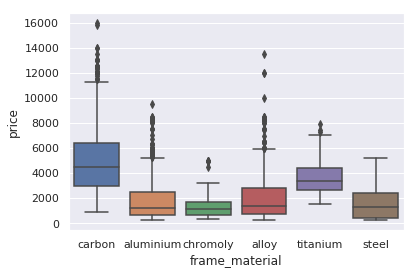

In [25]:
sns.boxplot(x=train_df.frame_material, y=train_df.price)

In [26]:
train_df['carbon_frame'] = train_df.frame_material.apply(lambda x: 1 if x == 'carbon' else 0)
train_df.carbon_frame.value_counts()

0    3916
1    2775
Name: carbon_frame, dtype: int64

In [27]:
train_df['titanium_frame'] = train_df.frame_material.map(lambda x: 1 if x == 'titanium' else 0)
train_df.titanium_frame.value_counts()

0    6643
1      48
Name: titanium_frame, dtype: int64

#### Other Material Categorical Fields
Except for fork material, we see that carbon material continues to have a strong relationship to price for other material based fields. So we will implement similar one-hot encoding to extract numerical features for these fields.

In [28]:
print(train_df.handlebar_material.value_counts())
grouped = train_df.groupby('handlebar_material')
grouped['price'].mean()

alloy        2161
carbon        818
aluminium     281
steel          38
chromoly        1
Name: handlebar_material, dtype: int64


handlebar_material
alloy        2289.059796
aluminium    2713.292206
carbon       7550.252983
chromoly     5400.000000
steel         526.151579
Name: price, dtype: float64

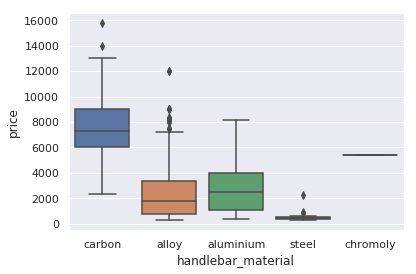

In [29]:
sns.boxplot(x=train_df.handlebar_material, y=train_df.price)

In [30]:
train_df['carbon_handlebar'] = train_df.handlebar_material.apply(lambda x: 1 if x == 'carbon' else 0)
train_df.carbon_handlebar.value_counts()

0    5873
1     818
Name: carbon_handlebar, dtype: int64

In [31]:
print(train_df.crankset_material.value_counts())
grouped = train_df.groupby('crankset_material')
grouped['price'].mean()

alloy        914
carbon       352
steel        166
aluminium    109
chromoly      14
titanium       1
Name: crankset_material, dtype: int64


crankset_material
alloy        1956.036575
aluminium    2623.416789
carbon       6660.852670
chromoly     1218.350000
steel        2230.340120
titanium     9599.990000
Name: price, dtype: float64

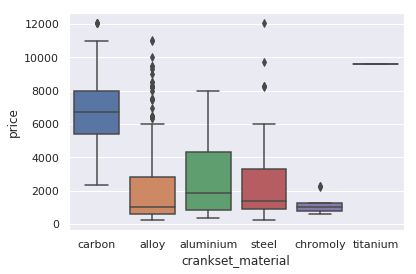

In [32]:
sns.boxplot(x=train_df.crankset_material, y=train_df.price)

In [33]:
train_df['carbon_crankset'] = train_df.crankset_material.apply(lambda x: 1 if x == 'carbon' else 0)
train_df.carbon_crankset.value_counts()

0    6339
1     352
Name: carbon_crankset, dtype: int64

In [34]:
print(train_df.seatpost_material.value_counts())
grouped = train_df.groupby('seatpost_material')
grouped['price'].mean()

alloy        1858
carbon        968
aluminium     148
steel          23
titanium        4
Name: seatpost_material, dtype: int64


seatpost_material
alloy        1474.797336
aluminium    2618.669865
carbon       5179.130940
steel         551.030870
titanium     5449.250000
Name: price, dtype: float64

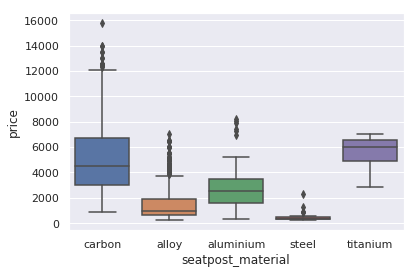

In [35]:
sns.boxplot(x=train_df.seatpost_material, y=train_df.price)

In [36]:
train_df['carbon_seatpost'] = train_df.seatpost_material.apply(lambda x: 1 if x == 'carbon' else 0)
train_df.carbon_seatpost.value_counts()

0    5723
1     968
Name: carbon_seatpost, dtype: int64

Alloy, aluminium, and carbon fork have relatively same average price. Surprisingly, having steel and chromoly fork has strong negative relationship to price. For this, we will implement one-hot encoding for steel and chromoly fork material; or rather one-hot encoding for non-carbon, alloy, aluminium for material.

In [37]:
print(train_df.fork_material.value_counts())
grouped = train_df.groupby('fork_material')
grouped['price'].mean()

carbon       1867
alloy         410
steel         386
chromoly      288
aluminium     227
titanium        1
Name: fork_material, dtype: int64


fork_material
alloy        2341.767024
aluminium    1907.530044
carbon       3540.693417
chromoly     1141.278368
steel        1006.329482
titanium     2459.000000
Name: price, dtype: float64

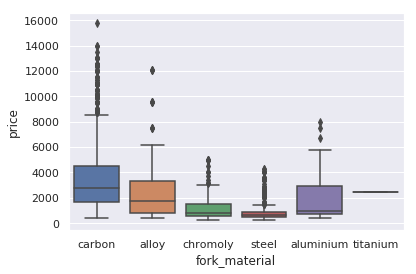

In [38]:
sns.boxplot(x=train_df.fork_material, y=train_df.price)

In [39]:
train_df['carbon_fork'] = train_df.fork_material.apply(lambda x: 1 if x == 'carbon' else 0)
train_df.carbon_fork.value_counts()

0    4824
1    1867
Name: carbon_fork, dtype: int64

#### Brake Type

In [40]:
print(train_df.brake_type.value_counts())
grouped = train_df.groupby('brake_type')
grouped['price'].mean()

disc                                                                                                          2771
hydraulic                                                                                                     1619
caliper                                                                                                        710
mechanical                                                                                                     184
vbrake                                                                                                         158
rim                                                                                                            128
linear_pull                                                                                                     60
coaster                                                                                                         24
Alloy Reach Adjustable                                                          

brake_type
160mm post-mount                                                                                               1932.333333
180mm post mount                                                                                               3299.000000
180mm post-mount                                                                                               3299.000000
180mm post-mount                                                                                               3299.000000
AXIS 1.0                                                                                                        799.990000
Aero integrated design (F&R)                                                                                   7999.000000
Alloy                                                                                                           849.990000
Alloy 3-Finger, Reach Adjustable                                                                                556.656667
Alloy

In [41]:
train_df[(train_df.brake_type == 'disc') | (train_df.brake_type == 'hydraulic') | (train_df.brake_type == 'mechanical')].mean()

price               3476.450896
msrp                3668.452280
model_year          2019.323936
carbon_frame           0.406865
titanium_frame         0.001093
carbon_handlebar       0.148010
carbon_crankset        0.062965
carbon_seatpost        0.102099
carbon_fork            0.216003
dtype: float64

In [42]:
train_df['disc_brakes'] = train_df.brake_type.apply(lambda x: 1 if x == 'disc' or x == 'hydraulic' or x == 'mechanical' else 0)
train_df.disc_brakes.value_counts()

1    4574
0    2117
Name: disc_brakes, dtype: int64

In [43]:
train_df['hydraulic_disc_brakes'] = train_df.brake_type.apply(lambda x: 1 if x == 'hydraulic' else 0)
train_df.hydraulic_disc_brakes.value_counts()

0    5072
1    1619
Name: hydraulic_disc_brakes, dtype: int64

In [44]:
train_df['mechanical_disc_brakes'] = train_df.brake_type.apply(lambda x: 1 if x == 'mechanical' else 0)
train_df.mechanical_disc_brakes.value_counts()

0    6507
1     184
Name: mechanical_disc_brakes, dtype: int64

In [45]:
train_df[train_df.brake_type == 'other'] ### DATA INTEGRITY ISSUES - NEED TO CLEAN UP DATA PIPELINE
# Seem to have framesets in samples and unnecessarily incomplete samples which have actual specs on website

,site,bike_type,product_id,href,description,brand,price,msrp,frame_material,model_year,...,shifter_groupset,carbon_frame,titanium_frame,carbon_handlebar,carbon_crankset,carbon_seatpost,carbon_fork,disc_brakes,hydraulic_disc_brakes,mechanical_disc_brakes


#### Model Year Field

In [46]:
# Summary statistics
train_df.model_year.describe()

count    2792.000000
mean     2019.281519
std         0.868396
min      2013.000000
25%      2019.000000
50%      2019.000000
75%      2020.000000
max      2020.000000
Name: model_year, dtype: float64

In [47]:
# Mode
train_df.model_year.mode()

0    2020.0
dtype: float64

In [48]:
# Counts by values
train_df.model_year.value_counts()

2020.0    1350
2019.0    1027
2018.0     309
2017.0      74
2016.0      23
2015.0       8
2013.0       1
Name: model_year, dtype: int64

The mean is about 2019, the median is 2019, and the mode is 2020. Let's set missing values to 2019.

In [49]:
train_df.loc[train_df.model_year.isnull(), 'model_year'] = 2019
train_df.model_year.describe()

count    6691.000000
mean     2019.117471
std         0.577825
min      2013.000000
25%      2019.000000
50%      2019.000000
75%      2019.000000
max      2020.000000
Name: model_year, dtype: float64

#### Groupset rank
Use groupset ranking based on price of groupset brand and types.

First task is to determine what to do with missing values. The groupset columns are related to a bike's drivetrain setup. Typically a bike's drivetrain is from the same groupset, with occaissional a level up/downgrade of certain components. Using this fact, for front derailleur, rear derailleiur, and shifters, if the other two match, then replacing with the same value for missing column.

In [50]:
groupset_cols = train_df.filter(regex='groupset').columns
groupset_cols

Index(['fd_groupset', 'rd_groupset', 'cassette_groupset', 'crankset_groupset',
       'chain_groupset', 'shifter_groupset'],
      dtype='object')

In [51]:
def update_if_matching(df: pd.DataFrame, idx: int, ref_cols: list) -> str:
    match_count = 0
    if df.loc[idx, ref_cols[0]] == df.loc[idx, ref_cols[1]]:
        return df.loc[idx, ref_cols[0]]
    return np.NaN    

In [52]:
null_fd_idx = train_df[train_df.fd_groupset.isnull()].index
null_rd_idx = train_df[train_df.rd_groupset.isnull()].index
null_shf_idx = train_df[train_df.shifter_groupset.isnull()].index

In [53]:
# update fd_groupste, rd_groupset, and shifter_groupset accordingly
for i in null_fd_idx:
    train_df.loc[i, 'fd_groupset'] = update_if_matching(df=train_df, idx=i,
                                                        ref_cols=['rd_groupset', 'shifter_groupset'])

for i in null_fd_idx:
    train_df.loc[i, 'rd_groupset'] = update_if_matching(df=train_df, idx=i,
                                                        ref_cols=['fd_groupset', 'shifter_groupset'])
    
for i in null_fd_idx:
    train_df.loc[i, 'shifter_groupset'] = update_if_matching(df=train_df, idx=i,
                                                        ref_cols=['rd_groupset', 'fd_groupset'])

count    4707.000000
mean        2.942607
std         1.180311
min         0.500000
25%         2.500000
50%         3.000000
75%         4.000000
max         5.500000
Name: fd_rank, dtype: float64


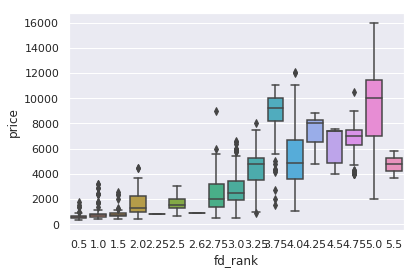

In [54]:
# add groupset rank columns for fd, rd, and shifters
train_df['fd_rank'] = train_df.fd_groupset.apply(lambda x: GROUPSET_RANKING.get(x, np.NaN))
print(train_df.fd_rank.describe())
sns.boxplot(x=train_df.fd_rank, y=train_df.price)

count    4817.000000
mean        2.970542
std         1.107255
min         0.500000
25%         2.500000
50%         3.000000
75%         4.000000
max         5.500000
Name: rd_rank, dtype: float64


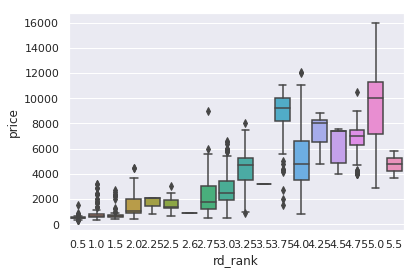

In [55]:
train_df['rd_rank'] = train_df.rd_groupset.apply(lambda x: GROUPSET_RANKING.get(x, np.NaN))
print(train_df.rd_rank.describe())
sns.boxplot(x=train_df.rd_rank, y=train_df.price)

count    4353.000000
mean        3.005307
std         1.087166
min         0.500000
25%         2.500000
50%         3.000000
75%         4.000000
max         6.000000
Name: shifter_rank, dtype: float64


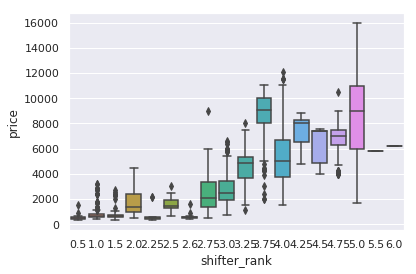

In [56]:
train_df['shifter_rank'] = train_df.shifter_groupset.apply(lambda x: GROUPSET_RANKING.get(x, np.NaN))
print(train_df.shifter_rank.describe())
sns.boxplot(x=train_df.shifter_rank, y=train_df.price)

In [57]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6691 entries, 4958 to 9547
Data columns (total 33 columns):
site                      6691 non-null object
bike_type                 6691 non-null object
product_id                6691 non-null object
href                      6691 non-null object
description               6691 non-null object
brand                     6691 non-null object
price                     6691 non-null float64
msrp                      6691 non-null float64
frame_material            6210 non-null object
model_year                6691 non-null float64
brake_type                6050 non-null object
fork_material             3179 non-null object
handlebar_material        3299 non-null object
fd_groupset               4852 non-null object
rd_groupset               4834 non-null object
cassette_groupset         5423 non-null object
crankset_material         1556 non-null object
crankset_groupset         3903 non-null object
seatpost_material         3001 non-null o

In [148]:
num_cols = train_df.describe().columns
model_df = train_df[num_cols]
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6691 entries, 4958 to 9547
Data columns (total 15 columns):
price                     6691 non-null float64
msrp                      6691 non-null float64
model_year                6691 non-null float64
carbon_frame              6691 non-null int64
titanium_frame            6691 non-null int64
carbon_handlebar          6691 non-null int64
carbon_crankset           6691 non-null int64
carbon_seatpost           6691 non-null int64
carbon_fork               6691 non-null int64
disc_brakes               6691 non-null int64
hydraulic_disc_brakes     6691 non-null int64
mechanical_disc_brakes    6691 non-null int64
fd_rank                   4707 non-null float64
rd_rank                   4817 non-null float64
shifter_rank              4353 non-null float64
dtypes: float64(6), int64(9)
memory usage: 1.1 MB


In [149]:
# drop rows with nas, create 'age' column, and then drop msrp and model_year
model_df = model_df.dropna(axis=0)
model_df['age'] = model_df.model_year.apply(lambda x: 2020 - x)
model_df = model_df.drop(columns=['msrp', 'model_year'])
model_df = model_df.loc[model_df.price < 5000,]
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3208 entries, 7052 to 2686
Data columns (total 14 columns):
price                     3208 non-null float64
carbon_frame              3208 non-null int64
titanium_frame            3208 non-null int64
carbon_handlebar          3208 non-null int64
carbon_crankset           3208 non-null int64
carbon_seatpost           3208 non-null int64
carbon_fork               3208 non-null int64
disc_brakes               3208 non-null int64
hydraulic_disc_brakes     3208 non-null int64
mechanical_disc_brakes    3208 non-null int64
fd_rank                   3208 non-null float64
rd_rank                   3208 non-null float64
shifter_rank              3208 non-null float64
age                       3208 non-null float64
dtypes: float64(5), int64(9)
memory usage: 375.9 KB


In [150]:
model_df.describe()

,price,carbon_frame,titanium_frame,carbon_handlebar,carbon_crankset,carbon_seatpost,carbon_fork,disc_brakes,hydraulic_disc_brakes,mechanical_disc_brakes,fd_rank,rd_rank,shifter_rank,age
count,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000
mean,2325.016213,0.335411,0.005611,0.024938,0.016833,0.131858,0.324813,0.762469,0.263716,0.045511,2.594405,2.659243,2.670277,0.898379
std,1348.567283,0.472208,0.074708,0.155959,0.128665,0.338389,0.468378,0.425637,0.440716,0.208455,1.075365,0.994622,0.970122,0.540494
min,299.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.000000
25%,1049.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,1.000000
50%,2199.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,3.000000,3.000000,1.000000
75%,3399.990000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,3.000000,3.000000,1.000000
max,4999.990000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000


In [151]:
corr = model_df.corr()
corr['price'].sort_values(ascending=False)

price                     1.000000
fd_rank                   0.755484
shifter_rank              0.736699
rd_rank                   0.736004
carbon_frame              0.556254
carbon_seatpost           0.285804
carbon_handlebar          0.231273
carbon_crankset           0.176920
carbon_fork               0.060899
titanium_frame            0.051804
age                      -0.025465
hydraulic_disc_brakes    -0.033276
disc_brakes              -0.033598
mechanical_disc_brakes   -0.217040
Name: price, dtype: float64

In [152]:
model_x = model_df.copy()
model_y = model_x.pop('price').values
model_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3208 entries, 7052 to 2686
Data columns (total 13 columns):
carbon_frame              3208 non-null int64
titanium_frame            3208 non-null int64
carbon_handlebar          3208 non-null int64
carbon_crankset           3208 non-null int64
carbon_seatpost           3208 non-null int64
carbon_fork               3208 non-null int64
disc_brakes               3208 non-null int64
hydraulic_disc_brakes     3208 non-null int64
mechanical_disc_brakes    3208 non-null int64
fd_rank                   3208 non-null float64
rd_rank                   3208 non-null float64
shifter_rank              3208 non-null float64
age                       3208 non-null float64
dtypes: float64(4), int64(9)
memory usage: 350.9 KB


In [153]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

In [154]:
regr.fit(X=model_x.values, y=model_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [155]:
regr.predict(model_x.values)

array([2669.20730676, 2208.57399649, 2763.93551592, ..., 2254.92805255,
       1776.53643035, 1086.98150787])

In [156]:
model_y

array([2649.  , 2199.  , 4500.  , ...,  926.99,  869.99,  950.  ])

In [157]:
model_x

,carbon_frame,titanium_frame,carbon_handlebar,carbon_crankset,carbon_seatpost,carbon_fork,disc_brakes,hydraulic_disc_brakes,mechanical_disc_brakes,fd_rank,rd_rank,shifter_rank,age
7052,1,0,0,0,1,1,0,0,0,3.00,3.00,3.00,1.0
6990,0,0,0,0,1,1,1,0,0,3.00,3.00,3.00,1.0
4878,0,0,0,0,0,1,0,0,0,4.00,4.00,4.00,0.0
1882,1,0,0,0,0,0,1,0,0,2.75,2.75,2.75,1.0
2643,0,0,0,0,0,0,0,0,0,3.00,3.00,3.00,1.0
6971,1,0,0,0,0,1,1,0,0,2.50,2.50,2.50,1.0
1812,0,0,0,0,0,0,1,0,0,2.75,2.75,2.75,1.0
2563,0,0,0,0,1,1,1,0,0,3.00,3.00,3.00,1.0
3443,0,0,0,0,0,0,0,0,0,0.50,0.50,1.50,1.0
2088,0,0,0,0,0,0,1,0,0,2.75,2.75,2.75,1.0


In [158]:
regr.score(model_x, model_y)

0.6651528001030775

In [159]:
enet = linear_model.ElasticNetCV(cv=1000)
enet.fit(X=model_x.values, y=model_y)

ElasticNetCV(alphas=None, copy_X=True, cv=1000, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [160]:
enet.predict(model_x.values)

array([2639.17303968, 2537.77161219, 3231.94302702, ..., 2198.79010951,
       2007.39599823, 1786.29783374])

In [161]:
enet.score(model_x, model_y)

0.5525208981609941

In [162]:
pd.set_option('display.max_columns', None)
model_df.loc[train_df.price > 10000,]

,price,carbon_frame,titanium_frame,carbon_handlebar,carbon_crankset,carbon_seatpost,carbon_fork,disc_brakes,hydraulic_disc_brakes,mechanical_disc_brakes,fd_rank,rd_rank,shifter_rank,age
